# High-Performance Computing in C++

This is a three-part series of tutorials that provides a foundation for understanding the computational performance of numerical applications.

## References

Hager and Wellein, Introduction to High Performance Computing for
Scientists and Engineers (Chapman & Hall/CRC Computational Science)

http://www.lighterra.com/papers/modernmicroprocessors/

https://www.cpu-world.com/CPUs/Xeon/Intel-Xeon%20E5-2683%20v3.html

https://www.cc.gatech.edu/~echow/ipcc/hpc-course/13_perf.pdf

https://sp.ts.fujitsu.com/dmsp/Publications/public/wp-haswell-ep-memory-performance-ww-en.pdf

https://www.cs.virginia.edu/stream/

# Architectures



...a tour of H&W chapter one...by the authors:

https://blogs.fau.de/hager/files/2020/10/01_architecture.pdf

## What *Is* High Performance?

One floating-point operation (FLOP):

```
double a, b = 1.0, c = 2.0;
a = b + c
```

How many of these can we do per second?  How many FLOP/S

Time it!

A simple C/C++ timer (in `timer.hh`):

```c++
#ifndef TIMER_HH_
#define TIMER_HH_
#include <sys/time.h>
#include <cstddef>
double time()
{
  struct timeval t;
  gettimeofday(&t, NULL);
  return (double)(t.tv_sec + t.tv_usec/1000000.0);
}
#endif // TIMER_HH__
```

And a `test_timer.cc`:

```c++
#include "timer.hh"
#include <cmath>
#include <cstdio>
int main()
{
  const int n = 1000000;
  const double delta = 1.0/(double)n;
  double s = 0;
  double t0 = time();
  for (int i = 0; i < n; ++i)
  {
    s += std::cos(i*delta) * delta;
  }
  double te = time()-t0;
  std::printf("       sin(1) ~= %10.6e\n", s);
  std::printf(" elapsed time =  %10.6e seconds\n", te);
}
```

# The "triad" test

Given for arrays/vectors/whatever `A`, `B`, `C`, and `D` of length `N`, compute the number of FLOPs to compute the following:

```python
  A = B + C * D
```



That's (1) an addition and (2) multiplication for each of `N` elements.

Hence, that's `2*N` FLOPs.  

## What Performance *Should* We See?

I ran this on my workstation using WSL2+Ubuntu.  My CPU is the [Intel Xeon 2683](https://www.cpu-world.com/CPUs/Xeon/Intel-Xeon%20E5-2683%20v3.html) for which I found some of the following details:

```
Frequency                  2000 MHz
Maximum turbo frequency    3000 MHz
Level 1 cache size         14 x 32 KB 8-way set associative instruction caches
                           14 x 32 KB 8-way set associative data caches
Level 2 cache size         14 x 256 KB 8-way set associative caches
Level 3 cache size         35 MB 20-way set associative shared cache
Extensions & Technologies  AVX2 (+ others)
Max memory bandwidth       68.3 GB/s  (= 17 GB/s x 4ch)
```

I'm not sure how/when turbo is activated, but these parameters suggest that I should see something on the order of a few GFLOP/s.

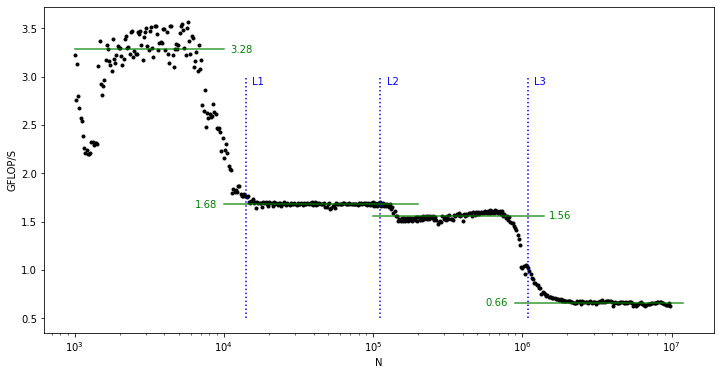

10.56 GB/s at 0.66 GFLOP/s


In [1]:
import numpy as np
import matplotlib.pyplot as plt
n, c, gflops = np.loadtxt('triad.txt', unpack=True)
plt.figure(1, figsize=(12,6))
plt.semilogx(n, gflops, 'k.')
m1 = np.mean(gflops[(n<8e3)*(n>2e3)])
m2 = np.mean(gflops[(n<1e5)*(n>2e4)])
m3 = np.mean(gflops[(n<9e5)*(n>2e5)])
m4 = np.mean(gflops[n>2e6])
plt.semilogx([1e3,1e4], [m1,m1], 'g', alpha=0.8);
plt.text(1.1*1e4, m1, f"{m1:.2f}", va='center', ha='left', color='g')
plt.semilogx([1e4,2e5], [m2,m2], 'g', alpha=0.8)
plt.text(0.9*1e4, m2, f"{m2:.2f}", va='center', ha='right', color='g')
plt.semilogx([1e5,1.4e6], [m3,m3], 'g', alpha=0.8)
plt.text(1.5*1e6, m3, f"{m3:.2f}", va='center', ha='left', color='g')
plt.semilogx([0.9*1e6,1.2*1e7], [m4,m4], 'g', alpha=0.8)
plt.text(0.8*1e6, m4, f"{m4:.2f}", va='center', ha='right', color='g')
plt.semilogx([14*32e3/(4*8)]*2, [.5, 3], 'b:')
plt.text(14*32e3/(4*8)*1.1, 3, "L1", va='top', ha='left', color='b')
plt.semilogx([14*256e3/(4*8)]*2, [.5, 3], 'b:')
plt.text(14*256e3/(4*8)*1.1, 3, "L2", va='top', ha='left', color='b')
plt.semilogx([35e6/(4*8)]*2, [.5, 3], 'b:')
plt.text(35e6/(4*8)*1.1, 3, "L3", va='top', ha='left', color='b')
plt.xlabel('N')
plt.ylabel('GFLOP/S')
plt.show()
print(f"{m4*2*8:.2f} GB/s at {m4:.2f} GFLOP/s")

The best performance is about 3 GFLOP/s.  Right order of magnide, but *not* optimal!

The performance takes hits at the expected locations, but the final bandwidth is way below the peak theoretical bandwidth!  However, my actual peak is probably closer to 46 GB/s due to my memory configration.

# Profiling

Given complex code, how do we figure out which parts we should improve?


First, compile with the `-pg` flag:

```
g++ -pg myprogram.cc -o myprogram
```


Run the code:

```
./myprogram # this produces gmon.out
```

Get the results:

```
gprof myprogram > results.txt
```

An alternative is Google's [gperftools](https://gperftools.github.io).  On Ubuntu, do

```
sudo apt install google-perftools
```

Then, include `profiler.h` in source code and link against `-lprofiler`


# OMILAT

How do we compute a matrix-vector product?  Write out the code!

Given $\mathbf{A}$ and $\mathbf{v}$ of sizes $n\times n$ and $n \times 1$, we have $\mathbf{y} = \mathbf{Av}$, or

```
for row in range(n):
    for column in range(n):
        y[row] = y[row] + A[row, column]*v[column]
```

which is $\mathbf{y} = [\mathbf{A}[0,:]\cdot \mathbf{v}, \mathbf{A}[1,:]\cdot \mathbf{v}, \ldots ]^T$, i.e., a sequence of dot products.

Alternatively

```
for column in range(n):
    for row in range(n):
        y[row] = y[row] + A[row, column]*v[column]
```

which is $\mathbf{y} = \mathbf{A}[:, 0] v[0] + \mathbf{A}[1, :] v[1] \ldots$, i.e., a combination of the columns of $\mathbf{A}$.

How do we compare to the experts?